# Projet R. Exploration Data Analysis & Feature Engineering &Random Forest

Luca DELANGLADE

In [1]:
library('ggplot2')
library('dplyr')
library('tidyr')
library('naniar')
library('GGally')
library('ggthemes')
library('gridExtra')
library('RColorBrewer')
library('caret')
library('e1071')
library('devtools')
library('caret')


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: 'GGally'

The following object is masked from 'package:dplyr':

    nasa


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: lattice
Loading required package: usethis


# Prétraitement des données

In [2]:
#I.Loading dataset
df <- read.csv('Assurance.csv', stringsAsFactors = F)

#II.Replacement by Na Values
NAN=df$Date.de.Soumission[1]
NAN2=df$Pathologie[1]
df<- df %>% replace_with_na_all(condition = ~.x %in% c(NAN,NAN2))

#III.Mode conversion
df$Taux.Escalation<-as.numeric(df$Taux.Escalation)
df$Capital<-as.numeric(df$Capital)
df$Pourcentage.Percu<-as.numeric(df$Pourcentage.Percu)
df$Chargement<-as.numeric(df$Chargement)
df$Salaire<-as.numeric(df$Salaire)
df$Generation<-as.numeric(df$Generation)
df$Categorie.Professionnelle<-as.numeric(df$Categorie.Professionnelle)


#IV.Character to numeric
df$Produit<-as.numeric(factor(df$Produit))

#V. Pathologies non renseignées
df$Pathologie<- factor(sapply(df$Pathologie, function(x) (if (is.na(x)) {x="Non-renseigné"} else {x=x})  ))

Warning message in eval(expr, envir, enclos):
"NAs introduits lors de la conversion automatique"Warning message in eval(expr, envir, enclos):
"NAs introduits lors de la conversion automatique"Warning message in eval(expr, envir, enclos):
"NAs introduits lors de la conversion automatique"Warning message in eval(expr, envir, enclos):
"NAs introduits lors de la conversion automatique"Warning message in eval(expr, envir, enclos):
"NAs introduits lors de la conversion automatique"Warning message in eval(expr, envir, enclos):
"NAs introduits lors de la conversion automatique"

On observe que la date la plus récente mentionnée dans ce fichier est le 23/12/2007, qui correspond à une date de fin de maladie. Par conséquent, nous placerons l'étude au 01/01/2008

In [5]:
#VI.Feature Creation
réf<-as.Date("01/01/2018", format="%d/%m/%Y")
df$age<- as.numeric((réf - as.Date(df$Date.de.Naissance, format="%d/%m/%Y"))/365)
df$maladie_ancienneté<- as.numeric((réf - as.Date(df$Debut.de.Maladie, format="%d/%m/%Y"))/365)
df$retreat_time<- as.numeric((as.Date(df$Date.de.Retraite, format="%d/%m/%Y")-réf)/365)
df$police_duration<- as.numeric((réf-as.Date(df$Date.de.Facturation, format="%d/%m/%Y"))/365)

#Target Creation
df$target<- factor(as.numeric(sapply(df$Fin.de.Maladie, function(x) if (is.na(x)) {x=0} else {x=1} )))

## Exploration Data Analysis

In [6]:
#I.Analyse de la dépendance à la target
#A.Exploration des données catégorielles
Target_Dependance_1<-function (df,feature,txtsize){
    ggplot(df,aes(x=as.factor(df[[feature]]),color=target))+
    geom_bar(alpha=0.4,position='dodge',fill='white')+
    theme(text = element_text(size=txtsize))+
    scale_x_discrete(name =feature)+
    theme(legend.position = "none")
}

#Target_Dependance_1_NAout=>ggplot(df[!is.na(df[[feature]]),],aes(x=as.factor(df[!is.na(df[[feature]]),][[feature]]),color=target))

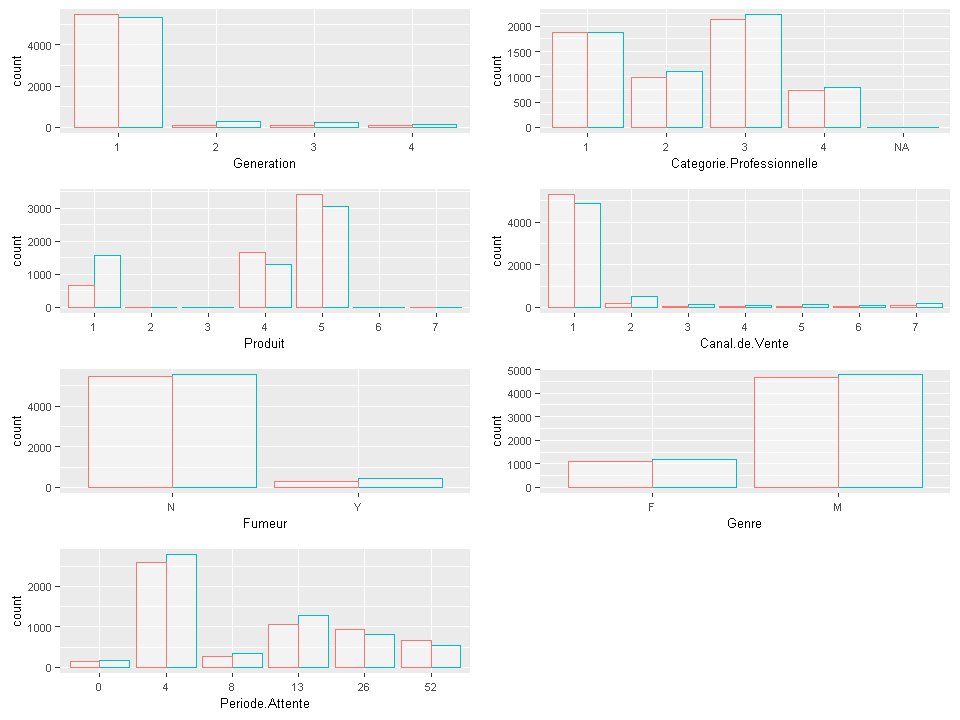

In [7]:
plot1<-Target_Dependance_1(df,"Generation",8)
plot2<-Target_Dependance_1(df,"Categorie.Professionnelle",8)
plot3<-Target_Dependance_1(df,"Produit",8)
plot4<-Target_Dependance_1(df,"Canal.de.Vente",8)
plot5<-Target_Dependance_1(df,"Fumeur",8)
plot6<-Target_Dependance_1(df,"Genre",8)
dx<-df[df$Periode.Attente %in% c(0,4,8,13,26,52),]
plot7<-Target_Dependance_1(dx,"Periode.Attente",8)

options(repr.plot.width=8, repr.plot.height=6)
grid.arrange(plot1, plot2, plot3, plot4, plot5, plot6, plot7, ncol=2)

Le dataset est constitué principalement de personnes de Génération 1.
Les Produits distribués sont principalement les produits 1,4 et 5. Le Produit 1 correspond à une plus forte probabilité de guérison.
Le Canal de vente 1 est très majoritaire par rapport aux autres canaux. Il correspond à une plus faible probabilité de guérison.
Les catégories professionnelles sont bien réparties dans le jeu de donnée. On observe que les catégories supérieures à 1 ont des probabilités de guérison supérieures.
La probabilité de guérison est plus forte pour une période d'attente inférieure à 13 mois.
Les variables Genre et Fumeurs ne sont pas très déterminantes.

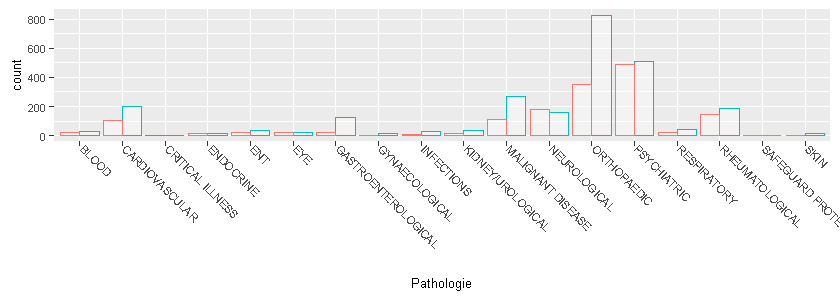

In [8]:
#Pathologies                          
options(repr.plot.width=7, repr.plot.height=2.5)
daz<-df[df$Pathologie!="Non-renseigné",]
Target_Dependance_1(daz,"Pathologie",8)+ 
theme(axis.text.x = element_text(angle = -45, hjust = 0, vjust=0))

On a crée une classe supplémentaire qui correspond aux pathologies non-renseignés. Cette classe a une influence négative sur la guérison. (Elle n'est pas représenté sur le barchart)

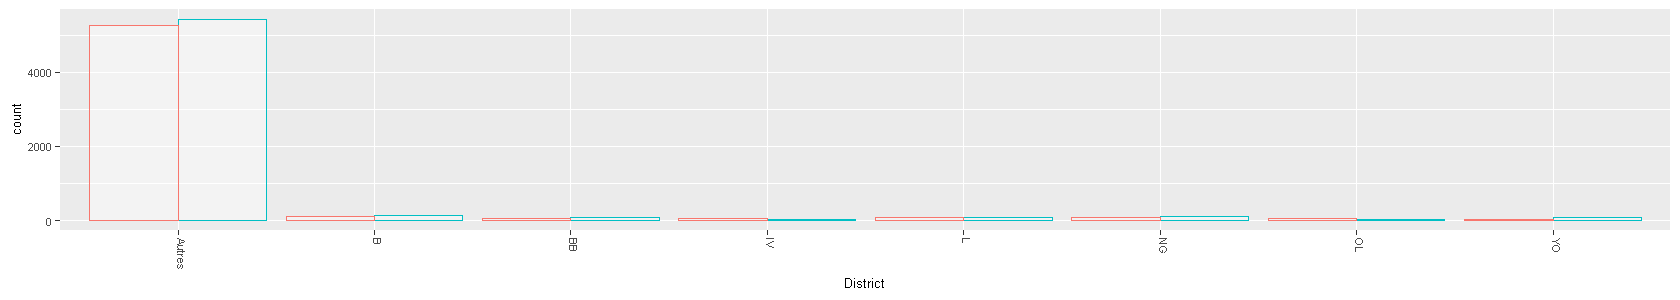

In [9]:
#District
options(repr.plot.width=14, repr.plot.height=2.5)
Target_Dependance_1(df,"District",8)+ 
theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0))
options(repr.plot.width=14, repr.plot.height=2.5)                     

#Les Districts ne sont pas très discriminants on les regroupes en 8 catégories comme suit: on prend les 7 catégories les plus discriminantes (voir prochain chart) et on regroupe toutes les autres.

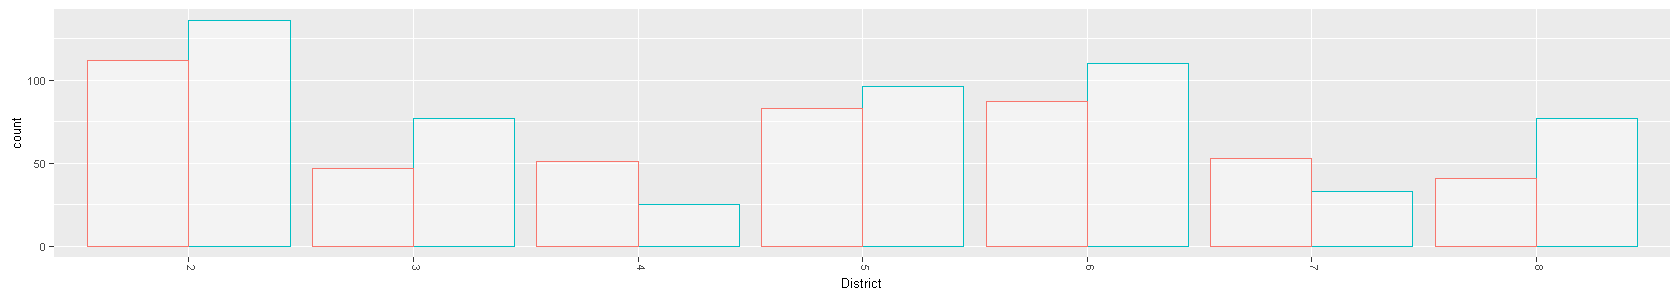

In [10]:
#Traitement: regroupement des catégories
D1<-c("B ","BB ","NG ","YO ","OL ","IV ","L ")
df$District<-factor(sapply(df$District, function(x) if (x %in% D1) {x=x} else {x="Autres"}))
#Plot                          
dy<-df[df$District!="Autres",]
options(repr.plot.width=14, repr.plot.height=2.5)
Target_Dependance_1(dy,"District",8)+ 
theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0))     
     

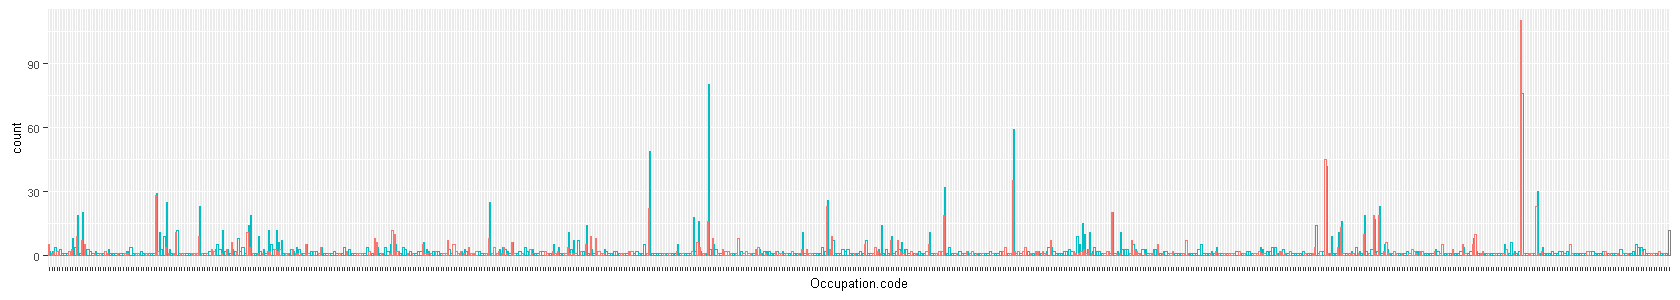

In [11]:
#Occupation.code
dz<-df[df$Occupation.code<9960,]
options(repr.plot.width=14, repr.plot.height=2.5)
Target_Dependance_1(dz,"Occupation.code",8)+ theme(axis.text.x=element_blank())

Certaines professions ont un impact très important sur la probabilité de guérison des patients.
Rq: Il y a une concentration au niveau des codes supérieurs à 9960. Ces codes correspondent à la catégorie "Non-renseigné" (non représenté dans le graphique au-dessus.
Comme pour les districts nous allons isoler les professions les plus discriminantes et regrouper les autres, en particulier, celle qui présente une faible fréquence.

In [12]:
df<-df %>% drop_na(Occupation.code)

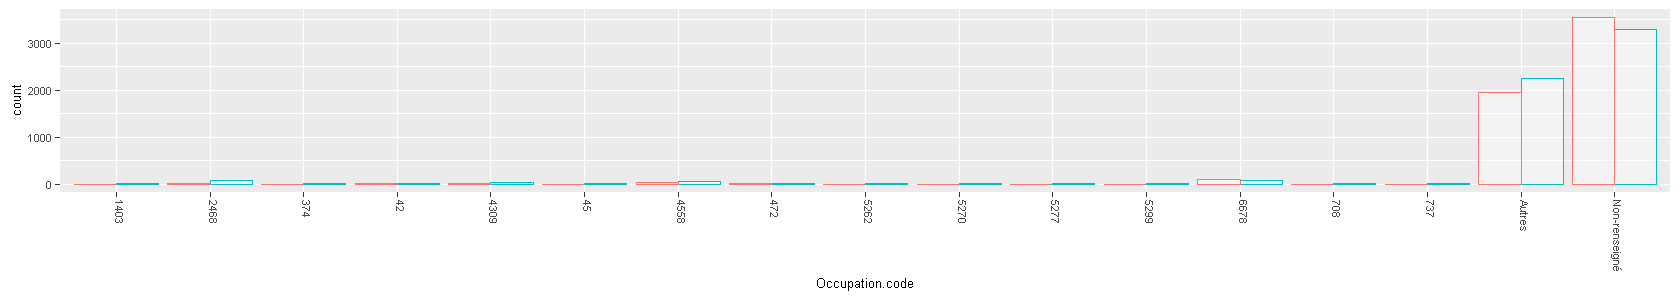

In [13]:
#Traitement: regroupement des catégories
Professions<-c(42,45,374,472,708,737,1403,2213,2468,4309,4558,5262,5270,5277,5299,6678)
df$Occupation.code<-factor(sapply(df$Occupation.code, function(x) if (x %in% Professions) {x=x} else if (x>9960) {x="Non-renseigné"} else {x="Autres"}))
#Plot
options(repr.plot.width=14, repr.plot.height=2.5)
Target_Dependance_1(df,"Occupation.code",8)+ 
theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0))     
     

In [14]:
#B.Exploration des données continues
Target_Dependance_2<-function (feature,xl){
    ggplot(df, aes(x=df[[feature]], color=target))+
    geom_density(fill="white", alpha=0.5, position="identity")+
    theme(text = element_text(size=8))+
    theme(legend.position = "none")+
    scale_x_continuous(name = paste("Dependence ",feature), limits = xl)
}

Warning message:
"Removed 1369 rows containing non-finite values (stat_density)."Warning message:
"Removed 1369 rows containing non-finite values (stat_density)."Warning message:
"Removed 476 rows containing non-finite values (stat_density)."Warning message:
"Removed 46 rows containing non-finite values (stat_density)."Warning message:
"Removed 1276 rows containing non-finite values (stat_density)."Warning message:
"Removed 1779 rows containing non-finite values (stat_density)."Warning message:
"Removed 7 rows containing non-finite values (stat_density)."

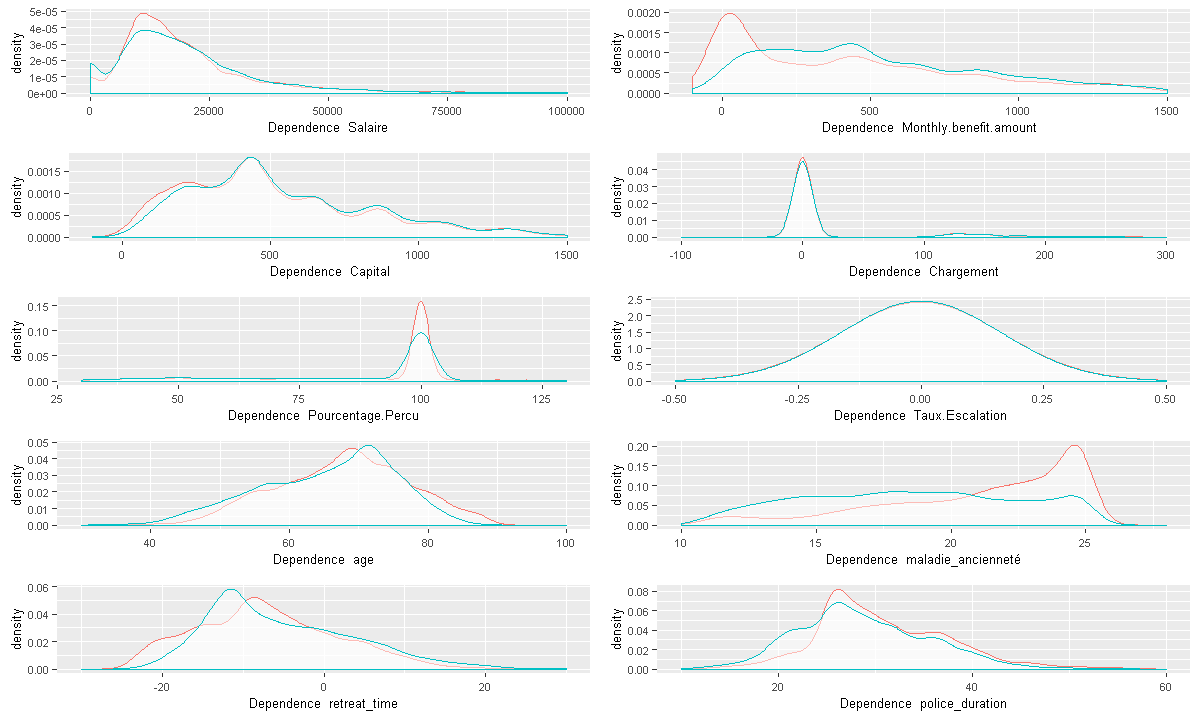

In [15]:
plot10<-Target_Dependance_2("Salaire",xl=c(0,100000))
plot20<-Target_Dependance_2("Monthly.benefit.amount",xl=c(-100,1500))
plot30<-Target_Dependance_2("Capital",xl=c(-100,1500))
plot40<-Target_Dependance_2("Chargement",xl=c(-100,300))
plot50<-Target_Dependance_2("Pourcentage.Percu",xl=c(30,130))
plot60<-Target_Dependance_2("Taux.Escalation",xl=c(-0.5,0.5))
plot100<-Target_Dependance_2("age",xl=c(30,100))
plot200<-Target_Dependance_2("maladie_ancienneté",xl=c(10,28))
plot300<-Target_Dependance_2("retreat_time",xl=c(-30,30))
plot400<-Target_Dependance_2("police_duration",xl=c(10,60))

options(repr.plot.width=10, repr.plot.height=6)
grid.arrange(plot10, plot20, plot30, plot40, plot50, plot60, plot100, plot200, plot300, plot400, ncol=2)

Le Chargement et le Taux d'Escalation ne sont pas des variables déterminantes

In [16]:
#II.Analyse des correlations
#A.Variables numériques
numeric_col <- c()
for (col in names(df)) {
    if (is.numeric(df[[col]])){numeric_col<-c(numeric_col,col)}
}

removal<-c('Numero.de.Police','Nombre.Assures','Chargement')
numeric_col<-numeric_col[!(numeric_col %in% removal)]
numeric_col

[1] "Generation"                "Monthly.benefit.amount"   
 [3] "Pourcentage.Percu"         "Salaire"                  
 [5] "Produit"                   "Categorie.Professionnelle"
 [7] "Capital"                   "Periode.Attente"          
 [9] "Taux.Escalation"           "Canal.de.Vente"           
[11] "age"                       "maladie_ancienneté"       
[13] "retreat_time"              "police_duration"

In [17]:
dg<- na.omit( df [c("age","retreat_time","police_duration","Capital","maladie_ancienneté","Canal.de.Vente","Produit","Generation","Categorie.Professionnelle","Pourcentage.Percu","Periode.Attente","Salaire","Monthly.benefit.amount")])
cor(dg)

,age,retreat_time,police_duration,Capital,maladie_ancienneté,Canal.de.Vente,Produit,Generation,Categorie.Professionnelle,Pourcentage.Percu,Periode.Attente,Salaire,Monthly.benefit.amount
age,1.000000000,-0.938988565,0.605045276,-0.22012851,0.29162602,-0.246241247,0.315528059,-0.333007088,-0.13470986,0.15406256,0.060758382,-0.003174416,-0.007444449
retreat_time,-0.938988565,1.000000000,-0.553069236,0.18349413,-0.28723423,0.229450065,-0.301948379,0.318228365,0.13031927,-0.13412820,-0.043953254,0.004737387,0.012513582
police_duration,0.605045276,-0.553069236,1.000000000,-0.36460785,0.32447052,-0.424515537,0.524092706,-0.471510001,-0.02010909,0.20993143,-0.157406736,-0.009224688,-0.026552814
Capital,-0.220128507,0.183494133,-0.364607846,1.00000000,-0.18572573,0.061425089,-0.104905165,0.104883329,-0.09256222,-0.12922644,0.046587117,0.112294497,0.045034369
maladie_ancienneté,0.291626019,-0.287234234,0.324470521,-0.18572573,1.00000000,-0.251155024,0.306786488,-0.322253921,0.05882985,0.10665168,-0.072103193,-0.065251417,-0.016308788
Canal.de.Vente,-0.246241247,0.229450065,-0.424515537,0.06142509,-0.25115502,1.000000000,-0.591706354,0.500055885,-0.13362350,-0.06862277,0.198468490,0.030262814,0.004449266
Produit,0.315528059,-0.301948379,0.524092706,-0.10490517,0.30678649,-0.591706354,1.000000000,-0.500754115,0.20206574,0.09716865,-0.277249508,-0.025801471,-0.007166845
Generation,-0.333007088,0.318228365,-0.471510001,0.10488333,-0.32225392,0.500055885,-0.500754115,1.000000000,-0.09901764,-0.04919873,0.124053564,0.015423587,0.005697834
Categorie.Professionnelle,-0.134709865,0.130319266,-0.020109089,-0.09256222,0.05882985,-0.133623497,0.202065744,-0.099017639,1.00000000,-0.02154359,-0.335402806,-0.072438266,-0.022957781
Pourcentage.Percu,0.154062555,-0.134128203,0.209931427,-0.12922644,0.10665168,-0.068622768,0.097168645,-0.049198734,-0.02154359,1.00000000,-0.019869322,0.020470796,-0.012921867


In [18]:
Violin_plot<-function (df,categorical,continuous,yl){
    ggplot(df,aes(x=factor(df[[categorical]]),y=df[[continuous]], fill=factor(df[[categorical]])))+
    geom_violin(trim=FALSE)+ 
    scale_fill_brewer(palette="Blues")+
    xlab(categorical)+
    ylab(continuous)+
    ylim(yl)+theme(text = element_text(size=8))+theme(legend.position = "none")
}

Warning message:
"Removed 86 rows containing missing values (geom_violin)."

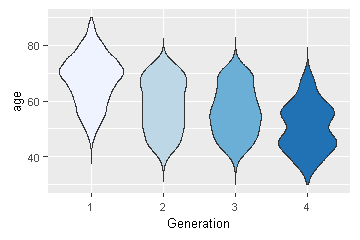

In [19]:
#Generation/age: cor=0.33
options(repr.plot.width=3, repr.plot.height=2)
Violin_plot(df,"Generation","age",c(30,90))

La Generation est corrélée à seulement 33% à l'âge, tandis que corrélée à 50% au Canal de Vente et au Produit. Nous allons investiguer.

Warning message:
"Removed 887 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 49 rows containing missing values (geom_violin)."Warning message:
"Removed 887 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 116 rows containing missing values (geom_violin)."

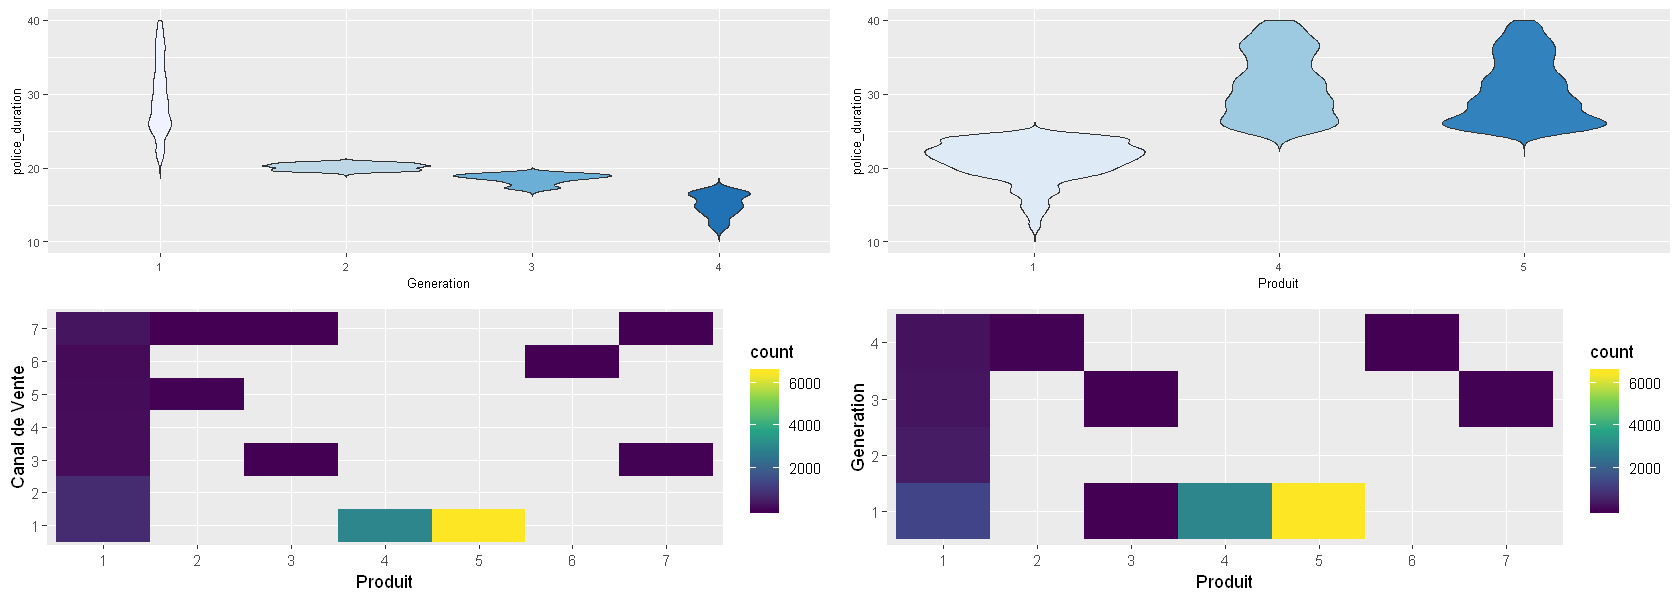

In [20]:
#Produit/Police_duration: cor=0.52
dr<-df[df$Produit %in% c(1,4,5),]
plotb<-Violin_plot(dr,"Produit","police_duration",c(10,40))
plota<-Violin_plot(dr,"Generation","police_duration",c(10,40))
#Produit/Canal de Vente: cor=0.59
plotc<-ggplot(df, aes(x=factor(Produit), y=factor(Canal.de.Vente)) ) +geom_bin2d(bins = 4) +
  scale_fill_continuous(type = "viridis") +xlab("Produit")+ylab("Canal de Vente")
#Produit/Generation: cor=0.50
plotd<-ggplot(df, aes(x=factor(Produit), y=factor(Generation)) ) +geom_bin2d(bins = 4) +
  scale_fill_continuous(type = "viridis") +xlab("Produit")+ylab("Generation")

options(repr.plot.width=14, repr.plot.height=5)
grid.arrange(plota, plotb, plotc, plotd, ncol=2)

La Generation correspond à l'antériorité de la police et est donc une variable qui n'a pas d'impact sur la guérison.
Le produit 1 est le produit principal de l'assureur, il a été contracté par toutes les Générations. Les produits 4 et 5 n'ont pas été commercialisés pour les Générations postérieures à la Génération 1. La produit n'est pas une variable déterminante du problème.
Le canal de vente correspond au mode de contractation de la police d'assurance, qui dépend du type de produit. Cette variable ne sera pas non plus prise en compte.


Warning message:
"Removed 1447 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 221 rows containing missing values (geom_violin)."

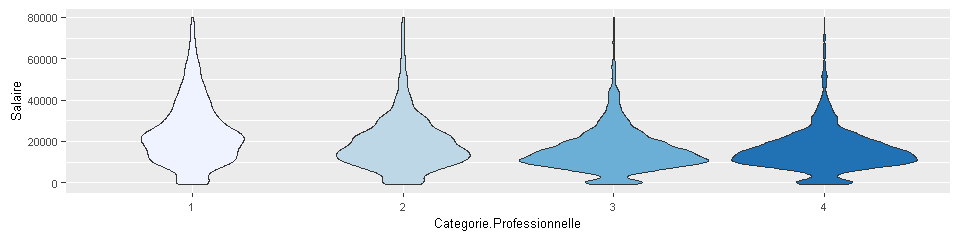

In [21]:
#Categorie/Salaire: cor=0.07
options(repr.plot.width=8, repr.plot.height=2)
Violin_plot(df,"Categorie.Professionnelle","Salaire",c(-1000,80000))

La Catégorie Professionnelle ne correspond pas au niveau social des individus mais au secteur d'activité et à la nature des métiers exercés: intellectuel/manuel etc.. C'est donc une variable importante du problème.

Warning message:
"Removed 361 rows containing non-finite values (stat_bin2d)."Warning message:
"Removed 1883 rows containing non-finite values (stat_bin2d)."Warning message:
"Removed 9 rows containing missing values (geom_tile)."Warning message:
"Removed 112 rows containing missing values (geom_point)."

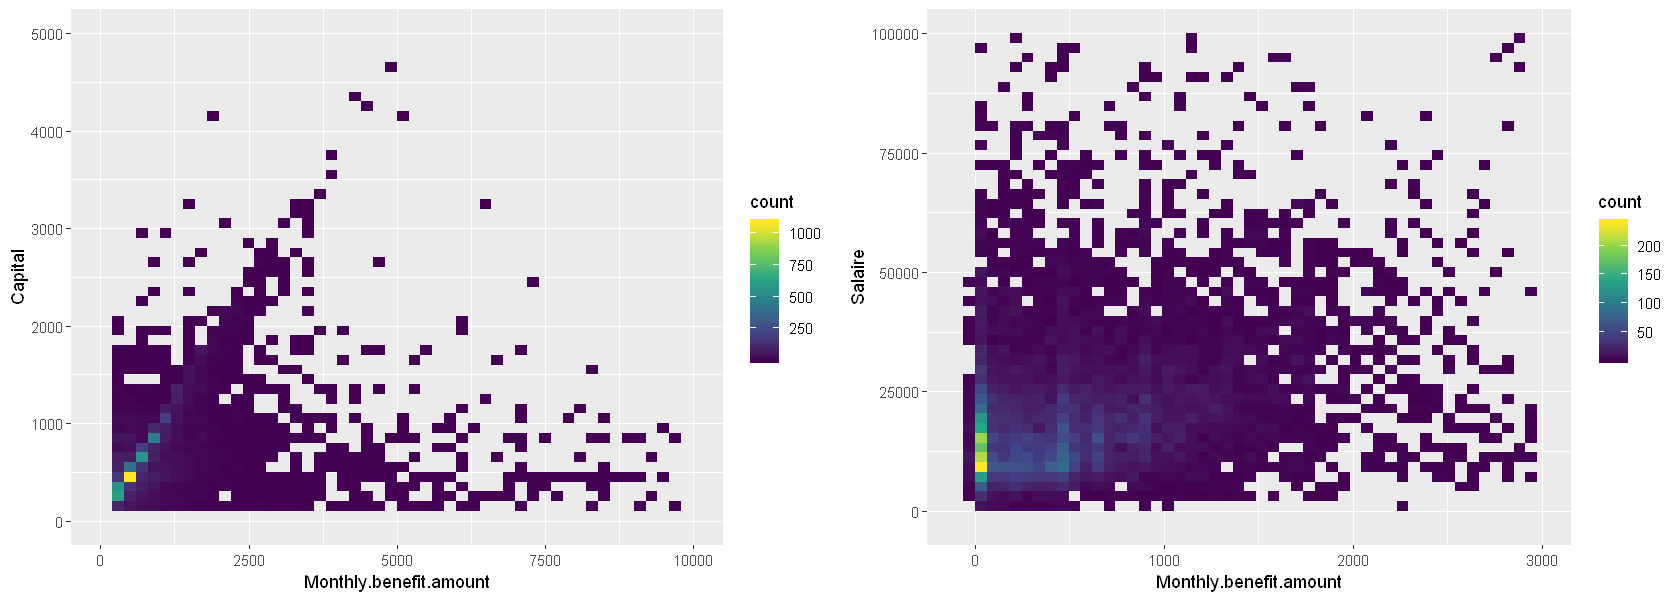

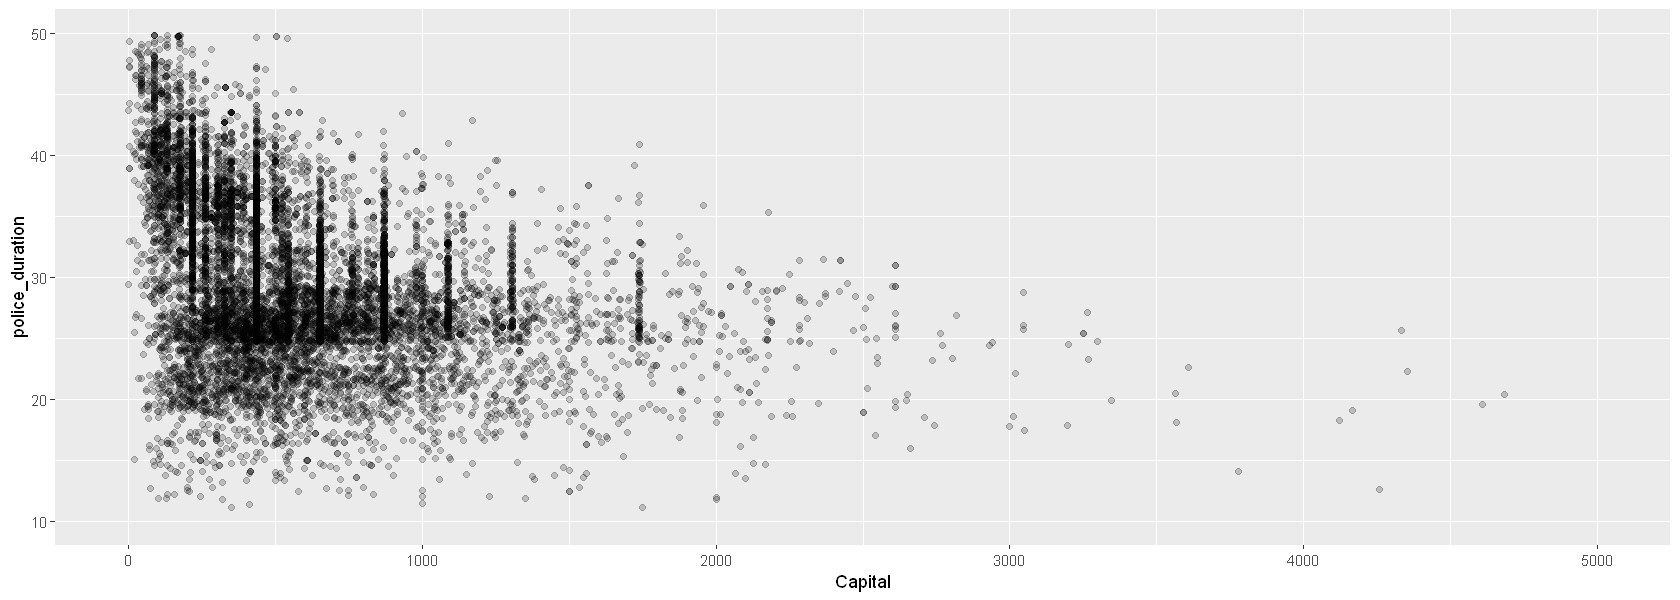

In [22]:
#Capital/Monthly.Benefit cor=0.04
plotA1<-ggplot(df, aes(x=Monthly.benefit.amount, y=Capital) ) +geom_bin2d(bins = 50) +
  scale_fill_continuous(type = "viridis") +xlim(c(0,10000))+ylim(c(0,5000))
#Salaire/Monthly.Benefit cor=0.00
plotA2<-ggplot(df, aes(x=Monthly.benefit.amount, y=Salaire) ) +geom_bin2d(bins = 50) +
  scale_fill_continuous(type = "viridis") +xlim(c(-100,3000))+ylim(c(-2000,100000))

options(repr.plot.width=14, repr.plot.height=5)
grid.arrange(plotA1, plotA2, ncol=2)

#Capital/police_duration
ggplot(df,aes(x=Capital,y=police_duration))+
geom_point(alpha=0.2)+
ylim(c(10,50))+xlim(c(0,5000))

Bien que la correlation soit très faible, il est intéressante d'observer la répartition Capital/monthly.benefit. Celle ci fait apparaitre une relation linéaire entre les deux qui indique que le Capital est bien lié au mode de rémunération de l'assurance vie. Le Capital est d'autant plus grand que la durée de la police d'assurance l'est aussi. C'est donc une variable importante du problème.

Warning message:
"Removed 190 rows containing missing values (geom_point)."

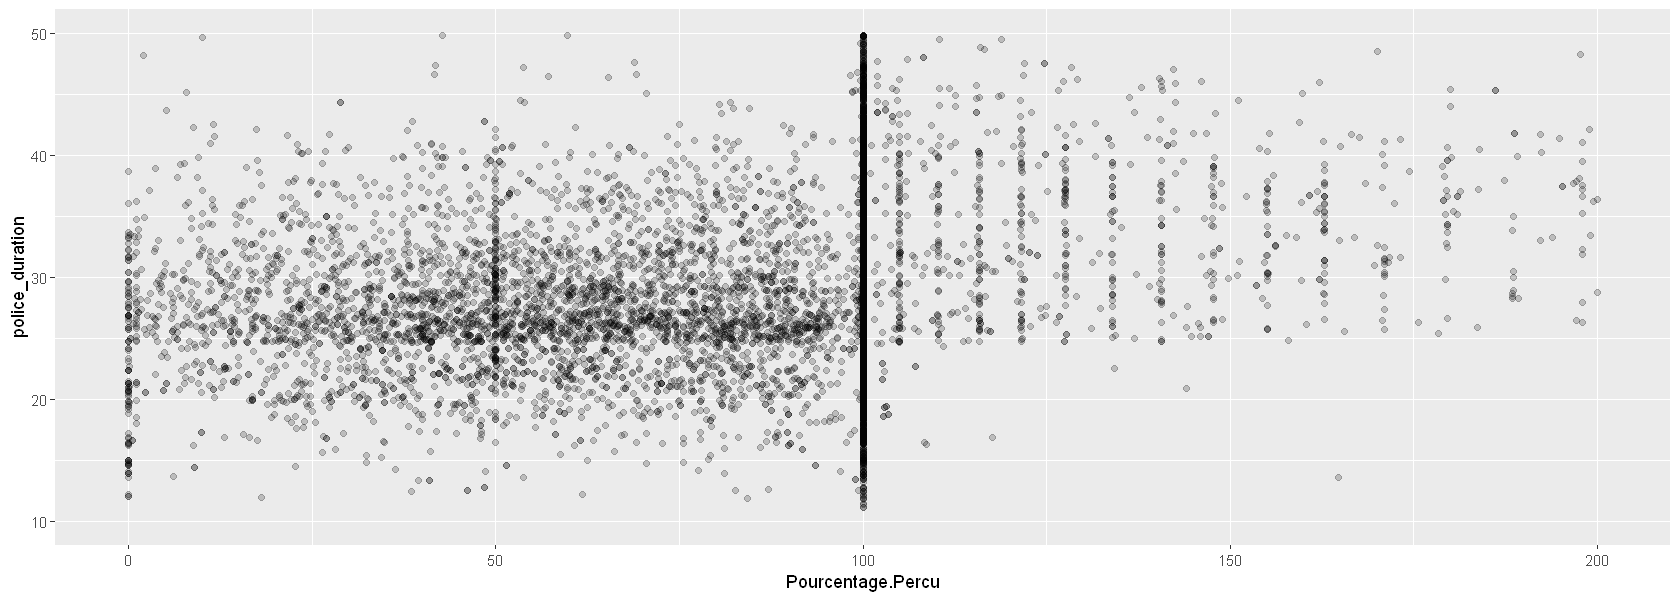

In [23]:
#Salaire/Pourcentage.Percu
ggplot(df,aes(x=Pourcentage.Percu,y=police_duration))+
geom_point(alpha=0.2)+
ylim(c(10,50))+xlim(c(0,200))

Seulement lorsque la police d'assurance dépasse 25 ans d'ancienneté, on observe un %perçu supérieur à 100.


# Partie 4: Preprocessing & Feature Engineering


In [24]:
#Feature Selection
Featureselected<-c("target","Pathologie","District","Occupation.code","Fumeur","Genre","age","retreat_time","police_duration","maladie_ancienneté","Periode.Attente","Salaire","Capital","Monthly.benefit.amount","Pourcentage.Percu")
df<-df[Featureselected]

In [25]:
#I.Traitement des valeurs manquantes
sapply(df,function (x) sum(is.na(x)))

target             Pathologie               District 
                     0                      0                      0 
       Occupation.code                 Fumeur                  Genre 
                     0                      0                      0 
                   age           retreat_time        police_duration 
                     0                      5                      0 
    maladie_ancienneté        Periode.Attente                Salaire 
                     0                      0                   1268 
               Capital Monthly.benefit.amount      Pourcentage.Percu 
                    23                      0                      3

On observe 1268 valeurs manquantes pour le salaire. Nous allons les remplacer par le salaire moyen correspondant à l'Occupation.code et à l'intervalle d'âge correspondant (cut(age,6))

In [26]:
#Traitement des valeurs manquantes pour le salaire
Data2<-df %>% 
group_by(cut(age,6))%>%
group_by(Occupation.code)%>%
mutate(Salairebygroup = mean(Salaire,na.rm = TRUE))%>% 
mutate(Salaire  = ifelse(is.na(Salaire), Salairebygroup, Salaire))
df$Salaire<-Data2$Salaire
#Pour les autres variables
df<- na.omit(df)

In [27]:
#II.Suppression des Outliers
sum(df$Salaire>200000)
sum(df$Monthly.benefit.amount>10000|df$Monthly.benefit.amount<(-5000))
sum(df$Pourcentage.Percu>200|df$Pourcentage.Percu<0)
sum(df$Periode.Attente>100)
df<-df[df$Salaire<200000,]
df<-df[df$Monthly.benefit.amount<10000&&df$Monthly.benefit.amount>(-5000),]
df<-df[df$Pourcentage.Percu<200&&df$Pourcentage.Percu>0,]
df<-df[df$Periode.Attente<100,]


[1] 24

[1] 91

[1] 98

[1] 44

In [31]:
#III.Label Encoding des variables binaires
df$Genre<-as.numeric(factor(df$Genre))
df$Fumeur<-as.numeric(factor(df$Fumeur))
df$Occupation.code<-as.factor(df$Occupation.code)
Databinary<-df[c("Genre","Fumeur")] 

In [32]:
#IV. One hot encoding pour les variables District, Patholgie & Occupation.code
dmy1 <- dummyVars(" ~ District", data = df, fullRank=T)
dmy2 <- dummyVars(" ~ Pathologie", data = df, fullrank=T)
dmy3 <- dummyVars(" ~ Occupation.code", data = df, fullrank=T)
District_onehot<- data.frame(predict(dmy1, df))
Pathologie_onehot<- data.frame(predict(dmy2, df))
Occupation_onehot<- data.frame(predict(dmy3, df))

In [35]:
#V.Partie numérique=>Minmax scaler
Numeric_Features<-c("age","retreat_time","police_duration","maladie_ancienneté","Periode.Attente","Salaire","Capital","Monthly.benefit.amount","Pourcentage.Percu")
Datanumeric=df[Numeric_Features]
head(Datanumeric)

age,retreat_time,police_duration,maladie_ancienneté,Periode.Attente,Salaire,Capital,Monthly.benefit.amount,Pourcentage.Percu
86.03014,-20.98356,57.22192,24.76986,52,17832,53,7,100
87.80822,-22.76438,57.15890,24.76986,52,6000,110,49,100
86.19452,-21.14795,57.09315,24.76986,4,5000,88,87,100
81.05205,-16.00822,56.96438,24.76986,26,24471,12,5,104
77.70137,-17.66027,56.80274,24.76986,4,5000,36,36,100
86.66575,-21.61918,56.57534,24.76986,0,10000,88,9,100


In [36]:
#VI.Compilation des variables dummifiées, numériques, binaires et de la target
target=df$target
X<-cbind(Pathologie_onehot,District_onehot,Occupation_onehot,Datanumeric,Databinary,target)
str(X)

'data.frame':	11609 obs. of  55 variables:
 $ Pathologie.BLOOD.........................: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.CARDIOVASCULAR................: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.CRITICAL.ILLNESS..............: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.ENDOCRINE.....................: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.ENT...........................: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.EYE...........................: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.GASTROENTEROLOGICAL...........: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.GYNAECOLOGICAL................: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.INFECTIONS....................: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.KIDNEY.UROLOGICAL.............: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.MALIGNANT.DISEASE.............: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.NEUROLOGICAL..................: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Pathologie.Non.renseigné                 : num  1 1 1 

In [136]:
head(X)

Pathologie.BLOOD.........................,Pathologie.CARDIOVASCULAR................,Pathologie.CRITICAL.ILLNESS..............,Pathologie.ENDOCRINE.....................,Pathologie.ENT...........................,Pathologie.EYE...........................,Pathologie.GASTROENTEROLOGICAL...........,Pathologie.GYNAECOLOGICAL................,Pathologie.INFECTIONS....................,Pathologie.KIDNEY.UROLOGICAL.............,...,police_duration,maladie_ancienneté,Periode.Attente,Salaire,Capital,Monthly.benefit.amount,Pourcentage.Percu,Genre,Fumeur,target
0,0,0,0,0,0,0,0,0,0,...,1.0000000,1,0.63414634,0.09139460,0.006838506,0.8731320,0.1019368,2,1,0
0,0,0,0,0,0,0,0,0,0,...,0.9986337,1,0.63414634,0.03075188,0.014334561,0.8731849,0.1019368,2,1,1
0,0,0,0,0,0,0,0,0,0,...,0.9972080,1,0.04878049,0.02562657,0.011441347,0.8732328,0.1019368,2,1,0
0,0,0,0,0,0,0,0,0,0,...,0.9944161,1,0.31707317,0.12542156,0.001446607,0.8731295,0.1060143,2,1,0
0,0,0,0,0,0,0,0,0,0,...,0.9909113,1,0.04878049,0.02562657,0.004602841,0.8731685,0.1019368,2,1,0
0,0,0,0,0,0,0,0,0,0,...,0.9859808,1,0.00000000,0.05125314,0.011441347,0.8731345,0.1019368,2,1,0


In [137]:
#VIII.Extraction pour les Machine Learner du groupe
#write.csv(X, file = "DataforML.csv")

## Partie 5: Building Models
L'étude des différents modèles est laissé aux soins de mon binome. Pour ma part, j'ai entraîné un Random Forest (ntree = 2000,mtry=30) qui performe à: 100% d'accuracy sur le training set et 80.8% sur le Test set. Je pense qu'un tuning efficace avec crossvalidation du RF ou bon réseau de neurone devrait viser au moins 90% d'accuracy sur le test set.

In [42]:
#Shuffle dataset
df <- df[sample(nrow(df)),]

# Random sample indexes
train_index <- sample(1:nrow(X), 0.75 * nrow(X))
test_index <- setdiff(1:nrow(X), train_index)

# Build X_train, y_train, X_test, y_test
X_train <- X[train_index, -55]
y_train <- X[train_index, "target"]

X_test <- X[test_index, -55]
y_test <- X[test_index, "target"]

#Fit Standard scaler for numeric features on X_train
pp = preProcess(X_train[Numeric_Features], method = "scale")

Numeric_train<-predict(pp,X_train[Numeric_Features])
X_train<-cbind(Numeric_train, select(X_train, -Numeric_Features))

Numeric_test<-predict(pp,X_test[Numeric_Features])
X_test<- cbind(Numeric_test,select(X_test, -Numeric_Features))


head(X_train)

,age,retreat_time,police_duration,maladie_ancienneté,Periode.Attente,Salaire,Capital,Monthly.benefit.amount,Pourcentage.Percu,Pathologie.BLOOD.........................,...,Occupation.code.5270,Occupation.code.5277,Occupation.code.5299,Occupation.code.6678,Occupation.code.708,Occupation.code.737,Occupation.code.Autres,Occupation.code.Non.renseigné,Genre,Fumeur
7868,6.018435,-0.88115492,3.804120,3.116868,0.2662772,1.346528,4.0291176,0.169491059,1.7253184,0,...,0,0,0,0,0,0,1,0,1,1
2054,8.212906,-1.56219965,5.292411,3.610914,0.2662772,1.125676,0.7133218,0.030006984,2.7827716,0,...,0,0,0,0,0,0,0,1,2,1
154,7.104576,-0.37554926,6.900404,5.394816,0.2662772,2.207693,0.2508131,0.010550843,1.1631985,0,...,0,0,0,0,0,0,0,1,2,1
4801,7.736972,-1.05232985,4.412604,4.939089,0.2662772,1.125676,1.5025778,0.063208259,2.7827716,0,...,0,0,0,0,0,0,0,1,2,1
119,8.623124,-2.00140649,7.085543,6.186521,0.0000000,0.891229,0.6511938,0.008614908,2.7827716,0,...,0,0,0,0,0,0,1,0,2,1
7218,6.304052,-0.07462252,3.901477,6.186521,0.2662772,1.425966,2.0019031,0.088859390,0.6010787,0,...,0,0,0,0,0,0,0,1,2,1


In [43]:
set.seed(123)
library(randomForest)
fit <- randomForest(y_train ~ ., data = X_train,ntree = 2000,mtry=30)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:gridExtra':

    combine

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin



In [44]:
#Performance:Training set
y_pred_train = predict(fit, newdata = X_train)
confusion_matrix=table(y_train, y_pred_train)
accuracy_train<-sum(diag(confusion_matrix)/sum(confusion_matrix))
print(confusion_matrix)
cat("\n","Accuracy sur l'échantillon de train: ",accuracy_train*100,"%")

       y_pred_train
y_train    0    1
      0 4264    0
      1    0 4442

 Accuracy sur l'échantillon de train:  100 %

In [45]:
#Performance: Test set
y_pred_test = predict(fit, newdata = X_test)
confusion_matrix=table(y_test, y_pred_test)
accuracy_test<-sum(diag(confusion_matrix)/sum(confusion_matrix))
print(confusion_matrix)
cat("\n","Accuracy sur l'échantillon de test: ",accuracy_test*100,"%")

      y_pred_test
y_test    0    1
     0 1121  284
     1  272 1226

 Accuracy sur l'échantillon de test:  80.8474 %

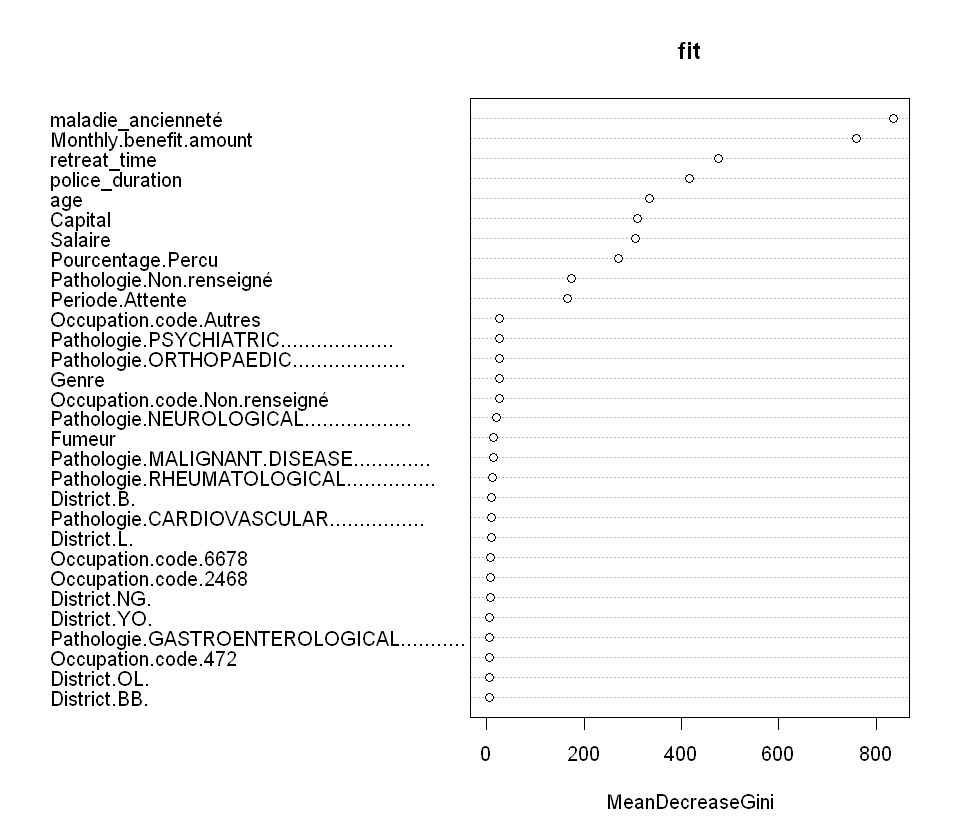

In [144]:
options(repr.plot.width=8, repr.plot.height=7)
varImpPlot(fit)

On observe que les variables les plus importantes du problème sont l'ancienneté de la maladie, la rémunération des retraités, et la durée avant la retraite.